# Evaluate Prompt Flows for "Simplify Language"

This notebooks uses the Promptflow SDK to run different variants and configurations of the "simplify" flow, and evaluate the results. You will be able to assess the relative quality and cost of different LLM models, prompt templates, parameter configurations etc. This enables an interactive, iterative cycle to evaluate and improve your flows.

In [1]:
%reload_ext autoreload
%autoreload 2
%pip install -r ../eval-simplify/requirements.txt -qqq
%pip install -r ./requirements.txt -qqq

# Download the German model for spaCy. Just do it once.
DOWNLOAD_SPACY=True
if (DOWNLOAD_SPACY) :
    !python -m spacy download de_core_news_sm -qqq


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [8]:

# Imports
import os
from promptflow.client import PFClient
from promptflow.entities import AzureOpenAIConnection, OpenAIConnection
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display, Markdown

# Helper function to prepare configs for different flow configurations
from helpers import create_flow_config, execute_run, execute_eval_run

# Supress default INFO logging
os.environ["PF_LOGGING_LEVEL"] = "CRITICAL"

In [3]:
# GLOBALS

# The required connection name (see flow.dag.yaml)
# Currently, must be OpenAI or Azure OpenAI connection.
conn_name = "openai_connection"

# Paths to the the flow and eval flow directory
flow_path="../flow-simplify-es"
eval_flow_path="../eval-simplify"

# Path to the test data
data_path="../test_data.jsonl"

In [4]:
#
# Create the Promptflow client 
#
pf = PFClient()

# Initialize the connection
conn = None

# Check if the connection already exists (e.g. already created, either here or via CLI). Promptflow stores the connection details locally (encrypted)
for c in pf.connections.list():
    if (c.name == conn_name) and (c.type == "OpenAI"):
        conn = pf.connections.get(name=conn_name)


if (conn is None):
    print(f"Connection '{conn_name}' not found, trying to create...")
    try:
        # use this for Azure OpenAI
        # Follow https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/create-resource?pivots=web-portal to create an Azure Open AI resource.
        #connection = AzureOpenAIConnection(
        #    name=conn_name,
        #    api_key="<user-input>",
        #    api_base="<test_base>",
        #    api_type="azure",
        #    api_version="<test_version>",
        #)
        
        # use this if you have an existing OpenAI account
        connection = OpenAIConnection(
            name=conn_name,
            api_key=os.environ.get("OPENAI_API_KEY") or "[ADD YOUR OPENAI API KEY HERE]",
        )
        conn = pf.connections.create_or_update(connection)
    except Exception as e:
        print(f"Failed to create connection: {e}")

if (conn):
    print (f"Connection '{conn_name}' is ready for use")
else: 
    print (f"Could ot find or create required connection, try setting the OPENAI_API_KEY environment variable.")

Connection 'openai_connection' is ready for use


### Run different variants of the '__simplify_es__' flow
The following cells create some different variants of the `flow-simplify-es` flow, following a simple naming convention. 
Existing runs with the same name will be overwritten. See output for links to trace information.
To edit the flow, open [flow.dag.yaml](../flow-simplify-es/flow.dag.yaml) file. We recommend using the Prompt Flow extension for Visual Studio Code, as it has a nice visual editor and other tooling.

We use the `prompflow.client` SDK to create runs, see `helpers.py` for details.

![flow-simplify-es DAG diagram](../_imgs/flow-diagram.png "The 'simplify_es' Flow")

#### Step 1: Create the flow configurations

In [5]:
# Create a few configurations to create flow runs with different models and variants
gpt4o_config = create_flow_config(model="gpt-4o")
gpt4o_config_2 = create_flow_config(model="gpt-4o",variant="${rules.short_instructions}")

gpt35turbo_config = create_flow_config(model="gpt-3.5-turbo")
gpt35turbo_config_2 = create_flow_config(model="gpt-3.5-turbo", variant="${rules.short_instructions}")

print ("The configs just hold the parameters for the runs, nothing special yet.\ne.g.:")
display(gpt35turbo_config_2)

The configs just hold the parameters for the runs, nothing special yet.
e.g.:


{'model': 'gpt-3.5-turbo',
 'display_name': 'Simplify ES gpt-3.5-turbo rules.short_instructions',
 'run_name': 'run_simplify_es_gpt-3.5-turbo_rules.short_instructions',
 'flow_path': '../flow-simplify-es',
 'data_path': '../test_data.jsonl',
 'variant': '${rules.short_instructions}',
 'column_mapping': {'original_text': '${data.original_text}',
  'model': 'gpt-3.5-turbo'}}

#### Step 2: Run the flows 
Run the flows using the configs from above (this will take a few moments). 
The execution creates so called `traces` (and log files), which can be inspected afterwards.

The trace urls look something like this:
- Collections: [http://127.0.0.1:23333/v1.0/ui/traces/#collection=flow-simplify-es](http://127.0.0.1:23333/v1.0/ui/traces/#collection=flow-simplify-es)
- Specific run: [http://127.0.0.1:23333/v1.0/ui/traces/?#run=run_simplify_es_gpt-4o_default](http://127.0.0.1:23333/v1.0/ui/traces/?#run=run_simplify_es_gpt-4o_default)

![Trace details](../_imgs/trace-flow-details.png "Trace details of a flow")

In [6]:
# Execute some runs. The results just store a bit more information about the run, like the run_id, the status, etc.

result_gpt4o = execute_run (pf, gpt4o_config)
result_gpt4o_2 = execute_run (pf, gpt4o_config_2)

result_gpt35turbo = execute_run (pf, gpt35turbo_config)
result_gpt35turbo_2 = execute_run (pf, gpt35turbo_config_2)



[2024-07-08 20:40:49 +0000][promptflow._sdk._orchestrator.run_submitter][INFO] - Submitting run run_simplify_es_gpt-4o_default, log path: /root/.promptflow/.runs/run_simplify_es_gpt-4o_default/logs.txt


Prompt flow service has started...
You can view the traces in local from http://127.0.0.1:23333/v1.0/ui/traces/?#run=run_simplify_es_gpt-4o_default


[2024-07-08 20:41:00 +0000][promptflow._sdk._orchestrator.run_submitter][INFO] - Submitting run run_simplify_es_gpt-4o_rules.short_instructions, log path: /root/.promptflow/.runs/run_simplify_es_gpt-4o_rules.short_instructions/logs.txt


Prompt flow service has started...
You can view the traces in local from http://127.0.0.1:23333/v1.0/ui/traces/?#run=run_simplify_es_gpt-4o_rules.short_instructions


[2024-07-08 20:41:11 +0000][promptflow._sdk._orchestrator.run_submitter][INFO] - Submitting run run_simplify_es_gpt-3.5-turbo_default, log path: /root/.promptflow/.runs/run_simplify_es_gpt-3.5-turbo_default/logs.txt


Prompt flow service has started...
You can view the traces in local from http://127.0.0.1:23333/v1.0/ui/traces/?#run=run_simplify_es_gpt-3.5-turbo_default


[2024-07-08 20:41:20 +0000][promptflow._sdk._orchestrator.run_submitter][INFO] - Submitting run run_simplify_es_gpt-3.5-turbo_rules.short_instructions, log path: /root/.promptflow/.runs/run_simplify_es_gpt-3.5-turbo_rules.short_instructions/logs.txt


Prompt flow service has started...
You can view the traces in local from http://127.0.0.1:23333/v1.0/ui/traces/?#run=run_simplify_es_gpt-3.5-turbo_rules.short_instructions


In [9]:
display(Markdown("#### Prompt Flow runs, sorted by __duration__ (in seconds)"))

pd.DataFrame ([result_gpt4o, 
               result_gpt4o_2, 
               result_gpt35turbo, 
               result_gpt35turbo_2]).drop (["run", "run_name", "details", "metrics"], axis=1).sort_values("duration")


#### Prompt Flow runs, sorted by __duration__ (in seconds)

,model,variant,duration,prompt_tokens,completion_tokens
3,gpt-3.5-turbo,${rules.short_instructions},7.197723,2430,740
2,gpt-3.5-turbo,None,9.150501,7950,706
1,gpt-4o,${rules.short_instructions},10.122532,1941,780
0,gpt-4o,None,10.230974,6751,926


#### Step 4: Compare simplified texts

A first, side-by-side comparison of the different simplified versions of the texts.

In [10]:
# Define the results and keys in a dictionary for easier processing. ["details"] contains the actual results as a DataFrame.

results = {
    "gpt-4o (default)": result_gpt4o["details"],
    "gpt-4o (rules.short_instructions)": result_gpt4o_2["details"],
    "gpt-3.5-turbo (default)": result_gpt35turbo["details"],
    "gpt-3.5-turbo (rules.short_instructions)": result_gpt35turbo_2["details"],
}

df = pd.concat({
    key: pd.DataFrame(details).set_index('inputs.original_text')['outputs.simplified_text'].rename(key)
    for key, details in results.items()
}, axis=1).head(5)

display(Markdown("#### `outputs.simplified_text` for different models and variants"))
df


#### `outputs.simplified_text` for different models and variants

,gpt-4o (default),gpt-4o (rules.short_instructions),gpt-3.5-turbo (default),gpt-3.5-turbo (rules.short_instructions)
inputs.original_text,,,,
"Als Vernehmlassungsverfahren wird diejenige Phase innerhalb des Vorverfahrens der Gesetzgebung bezeichnet, in der Vorhaben des Bundes von erheblicher politischer, finanzieller, wirtschaftlicher, ökologischer, sozialer oder kultureller Tragweite auf ihre sachliche Richtigkeit, Vollzugstauglichkeit und Akzeptanz hin geprüft werden. Die Vorlage wird zu diesem Zweck den Kantonen, den in der Bundesversammlung vertretenen Parteien, den Dachverbänden der Gemeinden, Städte und der Berggebiete, den Dachverbänden der Wirtschaft sowie weiteren, im Einzelfall interessierten Kreisen unterbreitet.","Das Vernehmlassungsverfahren ist ein Teil der Gesetzgebung.\n\nIn diesem Teil prüft der Bund neue Gesetze.\n\nDer Bund prüft, ob die Gesetze richtig und umsetzbar sind.\n\nDer Bund prüft auch, ob die Menschen die Gesetze akzeptieren.\n\nDer Bund schickt die Gesetze an verschiedene Gruppen.\n\nDiese Gruppen sind zum Beispiel:\n\n- Die Kantone.\n- Die Parteien im Parlament.\n- Die Verbände der Städte und Gemeinden.\n- Die Verbände der Wirtschaft.\n- Andere interessierte Gruppen.\n\nDiese Gruppen geben ihre Meinung zu den Gesetzen ab.","Das Vernehmlassungsverfahren ist ein Teil der Gesetzgebung. In dieser Phase prüft man Vorschläge des Bundes. Diese Vorschläge sind wichtig für Politik, Geld, Wirtschaft, Umwelt, Gesellschaft oder Kultur. Man prüft, ob die Vorschläge richtig und umsetzbar sind. Auch schaut man, ob die Leute die Vorschläge gut finden. \n\nDie Vorschläge gehen an verschiedene Gruppen. Dazu gehören die Kantone und die Parteien im Parlament. Auch die Verbände der Gemeinden, Städte und Berggebiete bekommen die Vorschläge. Außerdem erhalten die Wirtschaftsverbände die Vorschläge. Manchmal bekommen auch andere interessierte Gruppen die Vorschläge.","In der Vernehmlassung prüft man wichtige Vorhaben des Bundes auf ihre Richtigkeit und Akzeptanz. Dazu werden die Pläne verschiedenen Gruppen vorgelegt, wie den Kantonen, Parteien, Gemeindeverbänden und Wirtschaftsverbänden.","Im Vernehmlassungsverfahren werden wichtige Bundesvorhaben auf ihre Richtigkeit und Akzeptanz geprüft. Dabei bekommen Kantone, Parteien, Gemeindeverbände und Wirtschaftsverbände die Vorlage zur Stellungnahme."
"Das in Artikel 26 aPartG vorgesehene Ehehindernis der eingetragenen Partnerschaft wurde aufgehoben und in Artikel 96 nZGB eingearbeitet. Es ist zu präzisieren, dass das Ehehindernis nur dann besteht, wenn eine frühere Ehe oder eine mit einer Drittperson begründete eingetragene Partnerschaft noch besteht bzw. nicht für ungültig erklärt oder aufgelöst worden ist. Folglich können zwei Personen, die nach Inkrafttreten der ZGB-Revision, d.h. nach dem 30. Juni 2022, im Ausland miteinander eine eingetragene Partnerschaft begründet haben, einander heiraten, sofern die allgemeinen Voraussetzungen von Artikel 43 f. IPRG und des materiellen Schweizer Eherechts erfüllt sind, ohne vorgängig ihre eingetragene Partnerschaft auflösen zu müssen (Bericht RK-N, Ziff. 5.3.3 und 7.1, Ausführungen zu Art. 96 E-ZGB).","Das Ehehindernis der eingetragenen Partnerschaft wurde geändert. Es steht jetzt in Artikel 96 des Zivilgesetzbuchs. Ein Ehehindernis besteht nur, wenn eine frühere Ehe oder eingetragene Partnerschaft noch besteht. Diese muss ungültig oder aufgelöst sein.\n\nNach dem 30. Juni 2022 können zwei Personen heiraten, auch wenn sie im Ausland eine eingetragene Partnerschaft haben. Sie müssen dafür die allgemeinen Voraussetzungen erfüllen. Diese stehen in Artikel 43 des internationalen Privatrechts und im Schweizer Eherecht. Sie müssen die eingetragene Partnerschaft nicht vorher auflösen.\n\nDiese Änderungen stehen im Bericht der Rechtskommission.","Das Ehehindernis aus Artikel 26 aPartG wurde aufgehoben. Es steht jetzt in Artikel 96 nZGB. Das Ehehindernis gilt, wenn eine frühere Ehe oder Partnerschaft noch besteht. Diese Ehe oder Partnerschaf

## Evaluate and Results in Detail

#### Step 1: Run evaluation flows against the runs
This uses the ouputs from the previous runs, as well as original data.  

In [11]:
#
# TODO make sure to update with latest token prices for LLMs. 
# Prompt token is the (full) input prompt (template + input text) and completion token is the output text.
# The costs are in USD and per 1k (one thousand) tokens.
# For OpnAI, see https://openai.com/api/pricing/
# For Azure OpenAI, see https://azure.microsoft.com/en-us/pricing/details/cognitive-services/openai-service/#pricing

eval_gpt4o = execute_eval_run(pf, 
                              gpt4o_config, 
                              result_gpt4o, 
                              prompt_token_cost=0.005, 
                              completion_token_cost=0.015)

eval_gpt4o_2 = execute_eval_run(pf, 
                                gpt4o_config_2, 
                                result_gpt4o_2,  
                                prompt_token_cost=0.005, 
                                completion_token_cost=0.015)

eval_gpt35turbo = execute_eval_run(pf, 
                                    gpt35turbo_config, 
                                    result_gpt35turbo,
                                    prompt_token_cost=0.0005, 
                                    completion_token_cost=0.0015)



eval_gpt35turbo_2 = execute_eval_run(pf, 
                                        gpt35turbo_config_2, 
                                        result_gpt35turbo_2,
                                        prompt_token_cost=0.0005, 
                                        completion_token_cost=0.0015)



[2024-07-08 20:43:27 +0000][promptflow._sdk._orchestrator.run_submitter][INFO] - Submitting run eval_run_simplify_es_gpt-4o_default, log path: /root/.promptflow/.runs/eval_run_simplify_es_gpt-4o_default/logs.txt


Prompt flow service has started...
You can view the traces in local from http://127.0.0.1:23333/v1.0/ui/traces/?#run=eval_run_simplify_es_gpt-4o_default


[2024-07-08 20:43:41 +0000][promptflow._sdk._orchestrator.run_submitter][INFO] - Submitting run eval_run_simplify_es_gpt-4o_rules.short_instructions, log path: /root/.promptflow/.runs/eval_run_simplify_es_gpt-4o_rules.short_instructions/logs.txt


Prompt flow service has started...
You can view the traces in local from http://127.0.0.1:23333/v1.0/ui/traces/?#run=eval_run_simplify_es_gpt-4o_rules.short_instructions


[2024-07-08 20:43:53 +0000][promptflow._sdk._orchestrator.run_submitter][INFO] - Submitting run eval_run_simplify_es_gpt-3.5-turbo_default, log path: /root/.promptflow/.runs/eval_run_simplify_es_gpt-3.5-turbo_default/logs.txt


Prompt flow service has started...
You can view the traces in local from http://127.0.0.1:23333/v1.0/ui/traces/?#run=eval_run_simplify_es_gpt-3.5-turbo_default


[2024-07-08 20:44:05 +0000][promptflow._sdk._orchestrator.run_submitter][INFO] - Submitting run eval_run_simplify_es_gpt-3.5-turbo_rules.short_instructions, log path: /root/.promptflow/.runs/eval_run_simplify_es_gpt-3.5-turbo_rules.short_instructions/logs.txt


Prompt flow service has started...
You can view the traces in local from http://127.0.0.1:23333/v1.0/ui/traces/?#run=eval_run_simplify_es_gpt-3.5-turbo_rules.short_instructions


#### Step 2: Compare Results
Compare evaluation results and metrics between the different evaluation flows.

In [13]:
# For readability, we want to drop some columns from the evaluation results
columns_to_drop = [
    "inputs.prompt",
    "inputs.line_number",
    "inputs.prompt_1k_token_cost",
    "inputs.completion_1k_token_cost",
    "outputs.score_improvement",
    "outputs.level_improvement"
]

##### GPT-4o (default)

In [14]:
eval_gpt4o["details"].drop(columns_to_drop, axis=1).head(5)

,inputs.model,inputs.original_text,inputs.simplified_text,outputs.original_score,outputs.simplified_score,outputs.original_level,outputs.simplified_level,outputs.total_cost
0,gpt-4o,"Als Vernehmlassungsverfahren wird diejenige Phase innerhalb des Vorverfahrens der Gesetzgebung bezeichnet, in der Vorhaben des Bundes von erheblicher politischer, finanzieller, wirtschaftlicher, ökologischer, sozialer oder kultureller Tragweite auf ihre sachliche Richtigkeit, Vollzugstauglichkeit und Akzeptanz hin geprüft werden. Die Vorlage wird zu diesem Zweck den Kantonen, den in der Bundesversammlung vertretenen Parteien, den Dachverbänden der Gemeinden, Städte und der Berggebiete, den Dachverbänden der Wirtschaft sowie weiteren, im Einzelfall interessierten Kreisen unterbreitet.","Das Vernehmlassungsverfahren ist ein Teil der Gesetzgebung.\n\nIn diesem Teil prüft der Bund neue Gesetze.\n\nDer Bund prüft, ob die Gesetze richtig und umsetzbar sind.\n\nDer Bund prüft auch, ob die Menschen die Gesetze akzeptieren.\n\nDer Bund schickt die Gesetze an verschiedene Gruppen.\n\nDiese Gruppen sind zum Beispiel:\n\n- Die Kantone.\n- Die Parteien im Parlament.\n- Die Verbände der Städte und Gemeinden.\n- Die Verbände der Wirtschaft.\n- Andere interessierte Gruppen.\n\nDiese Gruppen geben ihre Meinung zu den Gesetzen ab.",2.620196,18.202793,C2,A2,0.007945
1,gpt-4o,"Das in Artikel 26 aPartG vorgesehene Ehehindernis der eingetragenen Partnerschaft wurde aufgehoben und in Artikel 96 nZGB eingearbeitet. Es ist zu präzisieren, dass das Ehehindernis nur dann besteht, wenn eine frühere Ehe oder eine mit einer Drittperson begründete eingetragene Partnerschaft noch besteht bzw. nicht für ungültig erklärt oder aufgelöst worden ist. Folglich können zwei Personen, die nach Inkrafttreten der ZGB-Revision, d.h. nach dem 30. Juni 2022, im Ausland miteinander eine eingetragene Partnerschaft begründet haben, einander heiraten, sofern die allgemeinen Voraussetzungen von Artikel 43 f. IPRG und des materiellen Schweizer Eherechts erfüllt sind, ohne vorgängig ihre eingetragene Partnerschaft auflösen zu müssen (Bericht RK-N, Ziff. 5.3.3 und 7.1, Ausführungen zu Art. 96 E-ZGB).","Das Ehehindernis der eingetragenen Partnerschaft wurde geändert. Es steht jetzt in Artikel 96 des Zivilgesetzbuchs. Ein Ehehindernis besteht nur, wenn eine frühere Ehe oder eingetragene Partnerschaft noch besteht. Diese muss ungültig oder aufgelöst sein.\n\nNach dem 30. Juni 2022 können zwei Personen heiraten, auch wenn sie im Ausland eine eingetragene Partnerschaft haben. Sie müssen dafür die allgemeinen Voraussetzungen erfüllen. Diese stehen in Artikel 43 des internationalen Privatrechts und im Schweizer Eherecht. Sie müssen die eingetragene Partnerschaft nicht vorher auflösen.\n\nDiese Änderungen stehen im Bericht der Rechtskommission.",5.120617,15.986202,C2,B1,0.008730
2,gpt-4o,"Die Änderung des RTVG stützt sich auf Artikel 93 BV. Dieser Artikel beinhaltet in Absatz 1 eine Zuständigkeitsvorschrift (Bundeskompetenz für die Gesetzgebung) und in den Absätzen 2–5 Rahmenbedingungen für die Wahrnehmung dieser Gesetzgebungskompetenz durch den Bund. Obwohl Artikel 93 BV unter der Sachüberschrift «Radio und Fernsehen» steht, werden in der Gesetzgebungskompetenz in Absatz 1 auch andere Medienformen genannt. So schliesst der Verfassungsgeber nebst Radio und Fernsehen explizit auch die Kategorie der «anderen Formen der öffentlichen fernmeldetechnischen Verbreitung von Darbietungen und Informationen» in die Regelungskompetenz des Bundes mit ein. Mit dieser Formulierung wurde ein Auffangtatbestand geschaffen, um die Bundeskompetenz für neue technologische Entwicklungen offenzuhalten. Historisch ausgelegt führt diese zukunftsgerichtete Regelung gemäss einem Grossteil der Lehre dazu, dass der Bund für den gesamten Bereich der fernmeldetechnisch verbreiteten Medien gesetzliche Regelungen vorsehen","Die Änderung des RTVG stützt sich auf Artikel 93 BV.\n\nDieser Artikel hat mehrere Absätze. \n\nAbsatz 1 sagt, dass de

##### GPT-4o (Variant: rules.short_instructions)

In [15]:
eval_gpt4o_2["details"].drop(columns_to_drop, axis=1).head(5)

,inputs.model,inputs.original_text,inputs.simplified_text,outputs.original_score,outputs.simplified_score,outputs.original_level,outputs.simplified_level,outputs.total_cost
0,gpt-4o,"Als Vernehmlassungsverfahren wird diejenige Phase innerhalb des Vorverfahrens der Gesetzgebung bezeichnet, in der Vorhaben des Bundes von erheblicher politischer, finanzieller, wirtschaftlicher, ökologischer, sozialer oder kultureller Tragweite auf ihre sachliche Richtigkeit, Vollzugstauglichkeit und Akzeptanz hin geprüft werden. Die Vorlage wird zu diesem Zweck den Kantonen, den in der Bundesversammlung vertretenen Parteien, den Dachverbänden der Gemeinden, Städte und der Berggebiete, den Dachverbänden der Wirtschaft sowie weiteren, im Einzelfall interessierten Kreisen unterbreitet.","Das Vernehmlassungsverfahren ist ein Teil der Gesetzgebung. In dieser Phase prüft man Vorschläge des Bundes. Diese Vorschläge sind wichtig für Politik, Geld, Wirtschaft, Umwelt, Gesellschaft oder Kultur. Man prüft, ob die Vorschläge richtig und umsetzbar sind. Auch schaut man, ob die Leute die Vorschläge gut finden. \n\nDie Vorschläge gehen an verschiedene Gruppen. Dazu gehören die Kantone und die Parteien im Parlament. Auch die Verbände der Gemeinden, Städte und Berggebiete bekommen die Vorschläge. Außerdem erhalten die Wirtschaftsverbände die Vorschläge. Manchmal bekommen auch andere interessierte Gruppen die Vorschläge.",2.620196,17.082174,C2,B1,0.003330
1,gpt-4o,"Das in Artikel 26 aPartG vorgesehene Ehehindernis der eingetragenen Partnerschaft wurde aufgehoben und in Artikel 96 nZGB eingearbeitet. Es ist zu präzisieren, dass das Ehehindernis nur dann besteht, wenn eine frühere Ehe oder eine mit einer Drittperson begründete eingetragene Partnerschaft noch besteht bzw. nicht für ungültig erklärt oder aufgelöst worden ist. Folglich können zwei Personen, die nach Inkrafttreten der ZGB-Revision, d.h. nach dem 30. Juni 2022, im Ausland miteinander eine eingetragene Partnerschaft begründet haben, einander heiraten, sofern die allgemeinen Voraussetzungen von Artikel 43 f. IPRG und des materiellen Schweizer Eherechts erfüllt sind, ohne vorgängig ihre eingetragene Partnerschaft auflösen zu müssen (Bericht RK-N, Ziff. 5.3.3 und 7.1, Ausführungen zu Art. 96 E-ZGB).","Das Ehehindernis aus Artikel 26 aPartG wurde aufgehoben. Es steht jetzt in Artikel 96 nZGB. Das Ehehindernis gilt, wenn eine frühere Ehe oder Partnerschaft noch besteht. Diese Ehe oder Partnerschaft muss ungültig erklärt oder aufgelöst sein. \n\nNach dem 30. Juni 2022 können zwei Personen im Ausland eine Partnerschaft eingehen. Sie dürfen dann trotzdem heiraten. Sie müssen ihre Partnerschaft nicht auflösen. Sie müssen aber die Regeln von Artikel 43 f. IPRG und dem Schweizer Eherecht beachten.",5.120617,16.549346,C2,B1,0.003605
2,gpt-4o,"Die Änderung des RTVG stützt sich auf Artikel 93 BV. Dieser Artikel beinhaltet in Absatz 1 eine Zuständigkeitsvorschrift (Bundeskompetenz für die Gesetzgebung) und in den Absätzen 2–5 Rahmenbedingungen für die Wahrnehmung dieser Gesetzgebungskompetenz durch den Bund. Obwohl Artikel 93 BV unter der Sachüberschrift «Radio und Fernsehen» steht, werden in der Gesetzgebungskompetenz in Absatz 1 auch andere Medienformen genannt. So schliesst der Verfassungsgeber nebst Radio und Fernsehen explizit auch die Kategorie der «anderen Formen der öffentlichen fernmeldetechnischen Verbreitung von Darbietungen und Informationen» in die Regelungskompetenz des Bundes mit ein. Mit dieser Formulierung wurde ein Auffangtatbestand geschaffen, um die Bundeskompetenz für neue technologische Entwicklungen offenzuhalten. Historisch ausgelegt führt diese zukunftsgerichtete Regelung gemäss einem Grossteil der Lehre dazu, dass der Bund für den gesamten Bereich der fernmeldetechnisch verbreiteten Medien gesetzliche Regelungen vorsehen","Die Änderung des RTVG stützt sich auf Artikel 93 BV. Artikel 93 BV regelt die Zuständigkeit des Bundes. Absatz 1 gibt dem Bund das Recht, Gesetze zu machen. Absätze 2 bis 5 g

##### GPT-3.5-turbo (Variant: default)

In [16]:
eval_gpt35turbo["details"].drop(columns_to_drop, axis=1).head(5)

,inputs.model,inputs.original_text,inputs.simplified_text,outputs.original_score,outputs.simplified_score,outputs.original_level,outputs.simplified_level,outputs.total_cost
0,gpt-3.5-turbo,"Als Vernehmlassungsverfahren wird diejenige Phase innerhalb des Vorverfahrens der Gesetzgebung bezeichnet, in der Vorhaben des Bundes von erheblicher politischer, finanzieller, wirtschaftlicher, ökologischer, sozialer oder kultureller Tragweite auf ihre sachliche Richtigkeit, Vollzugstauglichkeit und Akzeptanz hin geprüft werden. Die Vorlage wird zu diesem Zweck den Kantonen, den in der Bundesversammlung vertretenen Parteien, den Dachverbänden der Gemeinden, Städte und der Berggebiete, den Dachverbänden der Wirtschaft sowie weiteren, im Einzelfall interessierten Kreisen unterbreitet.","In der Vernehmlassung prüft man wichtige Vorhaben des Bundes auf ihre Richtigkeit und Akzeptanz. Dazu werden die Pläne verschiedenen Gruppen vorgelegt, wie den Kantonen, Parteien, Gemeindeverbänden und Wirtschaftsverbänden.",2.620196,13.758570,C2,B2,0.000826
1,gpt-3.5-turbo,"Das in Artikel 26 aPartG vorgesehene Ehehindernis der eingetragenen Partnerschaft wurde aufgehoben und in Artikel 96 nZGB eingearbeitet. Es ist zu präzisieren, dass das Ehehindernis nur dann besteht, wenn eine frühere Ehe oder eine mit einer Drittperson begründete eingetragene Partnerschaft noch besteht bzw. nicht für ungültig erklärt oder aufgelöst worden ist. Folglich können zwei Personen, die nach Inkrafttreten der ZGB-Revision, d.h. nach dem 30. Juni 2022, im Ausland miteinander eine eingetragene Partnerschaft begründet haben, einander heiraten, sofern die allgemeinen Voraussetzungen von Artikel 43 f. IPRG und des materiellen Schweizer Eherechts erfüllt sind, ohne vorgängig ihre eingetragene Partnerschaft auflösen zu müssen (Bericht RK-N, Ziff. 5.3.3 und 7.1, Ausführungen zu Art. 96 E-ZGB).","Das Gesetz hat geändert. Früher durften Personen nicht heiraten, wenn sie schon verheiratet waren oder eine eingetragene Partnerschaft mit jemand anderem hatten. Jetzt dürfen Personen, die nach dem 30. Juni 2022 im Ausland eine eingetragene Partnerschaft eingegangen sind, heiraten. Sie müssen ihre Partnerschaft nicht auflösen. Es gelten die üblichen Regeln für Eheschließungen.",5.120617,15.953655,C2,B1,0.000923
2,gpt-3.5-turbo,"Die Änderung des RTVG stützt sich auf Artikel 93 BV. Dieser Artikel beinhaltet in Absatz 1 eine Zuständigkeitsvorschrift (Bundeskompetenz für die Gesetzgebung) und in den Absätzen 2–5 Rahmenbedingungen für die Wahrnehmung dieser Gesetzgebungskompetenz durch den Bund. Obwohl Artikel 93 BV unter der Sachüberschrift «Radio und Fernsehen» steht, werden in der Gesetzgebungskompetenz in Absatz 1 auch andere Medienformen genannt. So schliesst der Verfassungsgeber nebst Radio und Fernsehen explizit auch die Kategorie der «anderen Formen der öffentlichen fernmeldetechnischen Verbreitung von Darbietungen und Informationen» in die Regelungskompetenz des Bundes mit ein. Mit dieser Formulierung wurde ein Auffangtatbestand geschaffen, um die Bundeskompetenz für neue technologische Entwicklungen offenzuhalten. Historisch ausgelegt führt diese zukunftsgerichtete Regelung gemäss einem Grossteil der Lehre dazu, dass der Bund für den gesamten Bereich der fernmeldetechnisch verbreiteten Medien gesetzliche Regelungen vorsehen","Die Änderung des RTVG basiert auf einem Artikel in der Verfassung. Dort steht, dass der Bund Gesetze machen kann für Radio, Fernsehen und andere Medien. So kann der Bund auch neue Technologien regeln. Diese Regelung gilt für alle Arten von Medien, die über Technologie verbreitet werden. Es ist wichtig, dass der Bund Gesetze für alle Medien machen kann.",9.881345,17.106143,C2,B1,0.000924
3,gpt-3.5-turbo,"Am 3. März 2024 haben Volk und Stände die Initiative für eine 13. AHV-Altersrente angenommen. Die Volksinitiative verlangt, dass die 13. Altersrente spätestens auf den 1. Januar 2026 umgesetzt wird. Vorgesehen sind zwei separaten Vorlagen, eine für die Umsetzung und eine

##### GPT-3.5-turbo (Variant: rules.short_instructions)

In [17]:
eval_gpt35turbo_2["details"].drop(columns_to_drop, axis=1).head(5)

,inputs.model,inputs.original_text,inputs.simplified_text,outputs.original_score,outputs.simplified_score,outputs.original_level,outputs.simplified_level,outputs.total_cost
0,gpt-3.5-turbo,"Als Vernehmlassungsverfahren wird diejenige Phase innerhalb des Vorverfahrens der Gesetzgebung bezeichnet, in der Vorhaben des Bundes von erheblicher politischer, finanzieller, wirtschaftlicher, ökologischer, sozialer oder kultureller Tragweite auf ihre sachliche Richtigkeit, Vollzugstauglichkeit und Akzeptanz hin geprüft werden. Die Vorlage wird zu diesem Zweck den Kantonen, den in der Bundesversammlung vertretenen Parteien, den Dachverbänden der Gemeinden, Städte und der Berggebiete, den Dachverbänden der Wirtschaft sowie weiteren, im Einzelfall interessierten Kreisen unterbreitet.","Im Vernehmlassungsverfahren werden wichtige Bundesvorhaben auf ihre Richtigkeit und Akzeptanz geprüft. Dabei bekommen Kantone, Parteien, Gemeindeverbände und Wirtschaftsverbände die Vorlage zur Stellungnahme.",2.620196,13.506470,C2,C1,0.000259
1,gpt-3.5-turbo,"Das in Artikel 26 aPartG vorgesehene Ehehindernis der eingetragenen Partnerschaft wurde aufgehoben und in Artikel 96 nZGB eingearbeitet. Es ist zu präzisieren, dass das Ehehindernis nur dann besteht, wenn eine frühere Ehe oder eine mit einer Drittperson begründete eingetragene Partnerschaft noch besteht bzw. nicht für ungültig erklärt oder aufgelöst worden ist. Folglich können zwei Personen, die nach Inkrafttreten der ZGB-Revision, d.h. nach dem 30. Juni 2022, im Ausland miteinander eine eingetragene Partnerschaft begründet haben, einander heiraten, sofern die allgemeinen Voraussetzungen von Artikel 43 f. IPRG und des materiellen Schweizer Eherechts erfüllt sind, ohne vorgängig ihre eingetragene Partnerschaft auflösen zu müssen (Bericht RK-N, Ziff. 5.3.3 und 7.1, Ausführungen zu Art. 96 E-ZGB).","Das Gesetz hat geändert: Wenn jemand eine eingetragene Partnerschaft hat, kann er jetzt heiraten. Aber nur wenn die Partnerschaft noch besteht oder nicht annulliert wurde. Ab dem 30. Juni 2022 können zwei Personen, die im Ausland eine Partnerschaft eingegangen sind, in der Schweiz heiraten. Dafür müssen sie die Regeln des Schweizer Eherechts und des Internationalen Privatrechts (IPRG) erfüllen. Sie müssen die Partnerschaft nicht vorher auflösen.",5.120617,16.122897,C2,B1,0.000389
2,gpt-3.5-turbo,"Die Änderung des RTVG stützt sich auf Artikel 93 BV. Dieser Artikel beinhaltet in Absatz 1 eine Zuständigkeitsvorschrift (Bundeskompetenz für die Gesetzgebung) und in den Absätzen 2–5 Rahmenbedingungen für die Wahrnehmung dieser Gesetzgebungskompetenz durch den Bund. Obwohl Artikel 93 BV unter der Sachüberschrift «Radio und Fernsehen» steht, werden in der Gesetzgebungskompetenz in Absatz 1 auch andere Medienformen genannt. So schliesst der Verfassungsgeber nebst Radio und Fernsehen explizit auch die Kategorie der «anderen Formen der öffentlichen fernmeldetechnischen Verbreitung von Darbietungen und Informationen» in die Regelungskompetenz des Bundes mit ein. Mit dieser Formulierung wurde ein Auffangtatbestand geschaffen, um die Bundeskompetenz für neue technologische Entwicklungen offenzuhalten. Historisch ausgelegt führt diese zukunftsgerichtete Regelung gemäss einem Grossteil der Lehre dazu, dass der Bund für den gesamten Bereich der fernmeldetechnisch verbreiteten Medien gesetzliche Regelungen vorsehen","Die Änderung des RTVG basiert auf Artikel 93 der Bundesverfassung. Dieser Artikel legt fest, dass der Bund das Recht hat, Gesetze zu erlassen. Dabei werden in den Absätzen 2-5 die Bedingungen dafür festgelegt. Obwohl Artikel 93 unter dem Titel ""Radio und Fernsehen"" steht, umfasst die Gesetzgebungskompetenz in Absatz 1 auch andere Medienformen. Neben Radio und Fernsehen erwähnt die Verfassung auch ""andere Formen der öffentlichen fernmeldetechnischen Verbreitung von Darbietungen und Informationen"". Damit soll sichergestellt werden, dass der Bund auch für neue Medientechnologien zuständig ist. Dies bedeutet, dass d

#### Metric Comparison table
Show the different metrics in a table, with median ZIX score improvements vs estimated cost.

In [20]:

metrics_df = pd.DataFrame( [eval_gpt4o["metrics"], 
               eval_gpt4o_2["metrics"], 
               eval_gpt35turbo["metrics"],
               eval_gpt35turbo_2["metrics"]], 
             index=["gpt-4o (default)", 
                    "gpt-4o (short instructions)", 
                    "gpt-3.5-turbo (default)", 
                    "gpt-3.5-turbo (short instructions)"]).sort_values(by="sum_total_cost", ascending=False)
display(metrics_df)

,avg_score_original,avg_score_simplified,median_score_simplified,max_score_simplified,min_score_simplified,avg_score_improvement,median_score_improvement,max_score_improvement,min_score_improvement,sum_total_cost
gpt-4o (default),6.675833,16.647762,16.181135,18.202793,15.438638,9.971930,9.216936,15.582597,6.645831,0.047495
gpt-4o (short instructions),6.675833,16.591463,16.549346,17.326849,15.464221,9.915630,9.242519,14.461978,6.999422,0.021255
gpt-3.5-turbo (default),6.675833,14.951081,15.472376,17.106143,12.464660,8.275248,7.224798,11.138374,5.937072,0.005019
gpt-3.5-turbo (short instructions),6.675833,14.967322,14.814267,16.122897,13.506470,8.291489,8.592566,11.002280,4.647819,0.002310


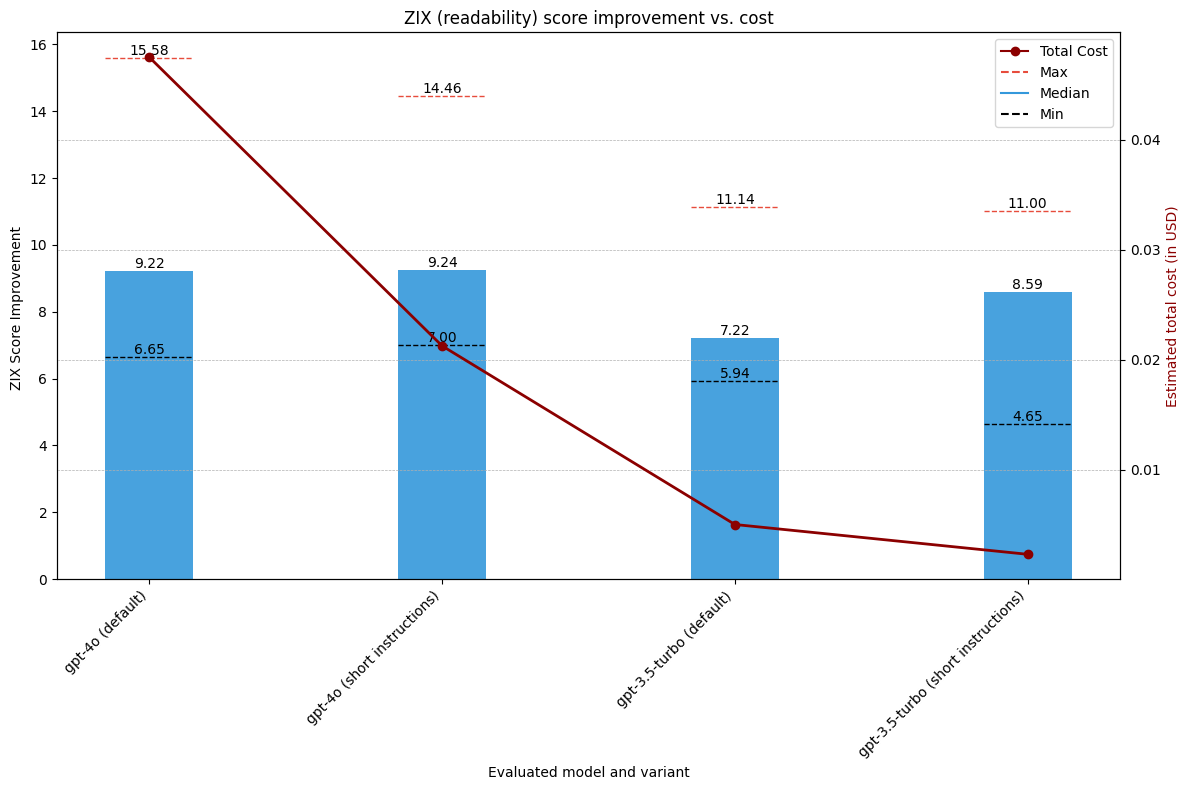

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming metrics_df is predefined
positions = np.arange(len(metrics_df))

# Define bar width
bar_width = 0.3

# Plotting setup
plt.figure(figsize=(12, 8))

# Plotting median_score_improvement as bars
bars = plt.bar(positions, metrics_df['median_score_improvement'], width=bar_width, color='#3498db', alpha=0.9, label='Median Score Improvement')

# Adding value labels to bars (median)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')


# Plotting dashed horizontal lines for min_score_improvement
for pos, value in zip(positions, metrics_df['min_score_improvement']):
    plt.hlines(y=value, xmin=pos - bar_width/2, xmax=pos + bar_width/2, colors='#000000', linewidth=1, linestyles='dashed')
    plt.text(pos, value, f'{value:.2f}', ha='center', va='bottom')


# Plotting dashed horizontal lines for max_score_improvement
for pos, value in zip(positions, metrics_df['max_score_improvement']):
    plt.hlines(y=value, xmin=pos - bar_width/2, xmax=pos + bar_width/2, colors='#e74c3c', linewidth=1, linestyles='dashed')
    plt.text(pos, value, f'{value:.2f}', ha='center', va='bottom')


# Setting the x-ticks and labels
plt.xticks(positions, metrics_df.index, rotation=45, ha="right")

# Adding labels and title
plt.xlabel('Evaluated model and variant')
plt.ylabel('ZIX Score Improvement ')
plt.title('ZIX (readability) score improvement vs. cost')

# Adding the secondary y-axis for total cost
ax2 = plt.gca().twinx()
ax2.plot(metrics_df.index, metrics_df['sum_total_cost'], color='darkred', marker='o', linestyle='-', linewidth=2, label='Sum Total Cost')
ax2.set_ylabel('Estimated total cost (in USD)', color='darkred')

# Adjusting the legend to include all elements
plt.legend(loc='upper center')
ax2.legend(loc='upper right')

# Adding gridlines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#ax2.grid(True, which='both', linestyle='--', linewidth=0.5, color='darkred')

# Improving the legend to differentiate between axes
plt.legend(handles=[plt.Line2D([0], [0], color='darkred', marker='o', linestyle='-', label='Total Cost'),
                    plt.Line2D([0], [0], color='#e74c3c',  label='Max', linestyle='dashed'),
                    plt.Line2D([0], [0], color='#3498db',  label='Median'),
                    plt.Line2D([0], [0], color='#000000',  label='Min', linestyle='dashed'),
                    ],
           loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()